# Faster R-CNN

## Utility Functions

In [1]:
import torch
import torchvision
import cv2
import os
from coco_labels import get_coco_labels
import json
import matplotlib.pyplot as plt
import numpy as np

def read_image(dataset_dir, image_name):
    image = cv2.imread(dataset_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_boxes(image, boxes, labels, scores, coco_labels):
    for box, label, score in zip(boxes, labels, scores):
        box = [int(coord) for coord in box]
        score = float(score)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        # Convert label ID to corresponding class name
        class_name = coco_labels[label]
        if class_name == "N/A":
            continue
        text = "{}: {:.2f}".format(class_name, score)
        cv2.putText(image, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

def predict_boxes(model, image_tensor, confidence_threshold, iou_threshold):
    # Forward pass through the model
    output = model(image_tensor)

    # Visualize predictions on the image
    boxes, labels, scores = output[0]['boxes'], output[0]['labels'], output[0]['scores']

    # Apply confidence thresholding
    keep = scores > confidence_threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

    # Perform non-maximum suppression using NMS
    keep_idxs = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)

    # Apply NMS to retain the most confident detections
    boxes, labels, scores = boxes[keep_idxs], labels[keep_idxs], scores[keep_idxs]

    return boxes, labels, scores

## Inference

The `torchvision.models.detection` module provides several pre-trained models for object detection, segmentation, and person keypoint detection, as well as some training utilities. For Faster R-CNN, the following models are available:

1. `fasterrcnn_resnet50_fpn`: This is a Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN). It's pre-trained on the COCO train2017 dataset.

2. `fasterrcnn_mobilenet_v3_large_fpn`: This is a Faster R-CNN model with a MobileNetV3-Large backbone and FPN. It's also pre-trained on the COCO train2017 dataset.

3. `fasterrcnn_mobilenet_v3_large_320_fpn`: This is another Faster R-CNN model with a MobileNetV3-Large backbone and FPN, but designed for 320x320 input images. It's pre-trained on the COCO train2017 dataset.

You can use these models like this:



In [ ]:
def inference(images, model, transform, confidence_threshold, iou_threshold, coco_labels, show=False, save=True, split='val'):

    total_predictions = {}
    output_dir = "output/" + split + "/confidence_threshold_" + str(confidence_threshold) + "_iou_threshold_" + str(iou_threshold) + "/"

    for sample in images:
        image = read_image(DATASET_DIR, sample)
        image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
        total_predictions[sample] = []
        boxes, labels, scores = predict_boxes(model, image_tensor, confidence_threshold, iou_threshold)
        image = plot_boxes(image, boxes, labels, scores, coco_labels)
        for box, label, score in zip(boxes, labels, scores):
            box = [int(coord) for coord in box]
            score = float(score)
            # Convert label ID to corresponding class name
            class_name = coco_labels[label]
            if class_name == "N/A":
                continue
            total_predictions[sample].append({"class_name": class_name, "score": score, "box": box})
        if show:
            cv2.imshow("Image", image)
            cv2.waitKey(0)
        if save:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            cv2.imwrite(output_dir + sample, image)

    # Saving the predictions dictionary to a JSON file
    with open(output_dir + "predictions.json", "w") as outfile:
        json.dump(total_predictions, outfile)

# Constants
DATASET_DIR = "dataset/val2017/"
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
coco_labels = get_coco_labels()
print("Loaded {} labels from COCO dataset".format(len(coco_labels)))

# Load the COCO dataset in "dataset/test2017" 
test_images = os.listdir(DATASET_DIR)
print("Loaded {} images from the COCO dataset".format(len(test_images)))

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
print(model)
print("Loaded pre-trained Faster R-CNN model trained on COCO")

# Print the number of classes detected by the model
print("Number of classes the model is trained on: ", model.roi_heads.box_predictor.cls_score.out_features)

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Applying inference on the images
inference(test_images, model, transform, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, coco_labels, show=True, save=False, split='val')

## Activation Visualization

Activation visualization is a technique used in deep learning to understand and analyze the behavior of neural networks. It involves visualizing the activations or outputs of individual neurons or layers within a neural network when given a particular input.

The main purpose of activation visualization is to gain insights into how the network is processing and representing the input data. By visualizing the activations, we can identify which parts of the input are being emphasized or ignored by the network. This can help us understand the network's decision-making process and potentially identify any issues or biases in the model.

In general, the process involves the following steps:

1. Load the pre-trained model: Activation visualization is typically performed on pre-trained models. The first step is to load the model architecture and weights.

2. Prepare the input data: Depending on the task, you need to prepare the input data that the model expects. This could involve preprocessing, resizing, or normalizing the input images.

3. Forward pass: Pass the input data through the model to obtain the activations. This involves feeding the input data through the layers of the model and collecting the activations at the desired layer(s).

4. Visualize the activations: Once you have obtained the activations, you can visualize them using various techniques such as heatmaps, feature maps, or activation histograms. These visualizations can provide insights into the learned representations and patterns within the network.

Loaded 91 labels from COCO dataset


c:\Users\Yousef\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yousef\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


first_layer_activations:  torch.Size([256, 107, 160])
last_layer_activations:  torch.Size([2048, 14, 20])


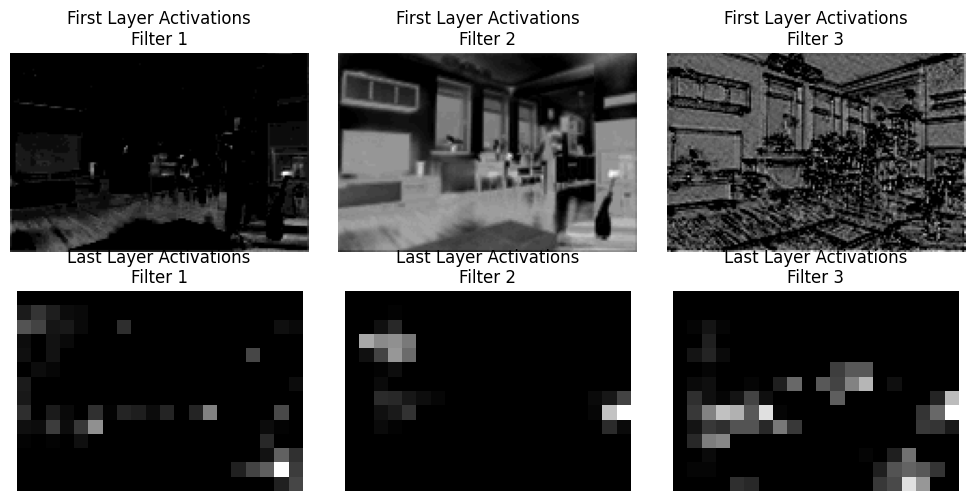

first_layer_activations:  torch.Size([256, 160, 147])
last_layer_activations:  torch.Size([2048, 20, 19])


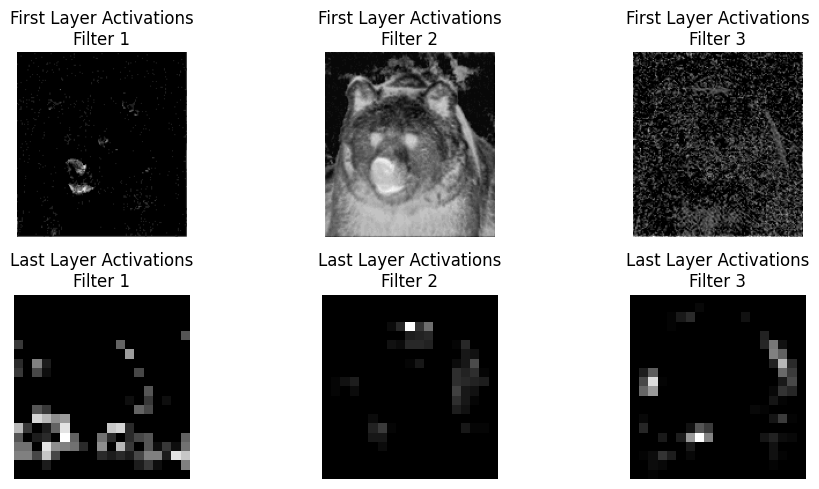

first_layer_activations:  torch.Size([256, 121, 160])
last_layer_activations:  torch.Size([2048, 16, 20])


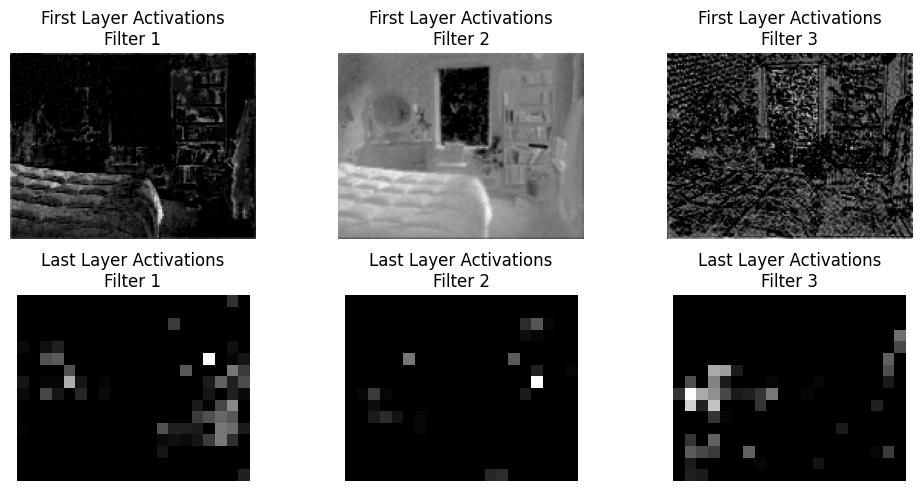

first_layer_activations:  torch.Size([256, 125, 94])
last_layer_activations:  torch.Size([2048, 16, 12])


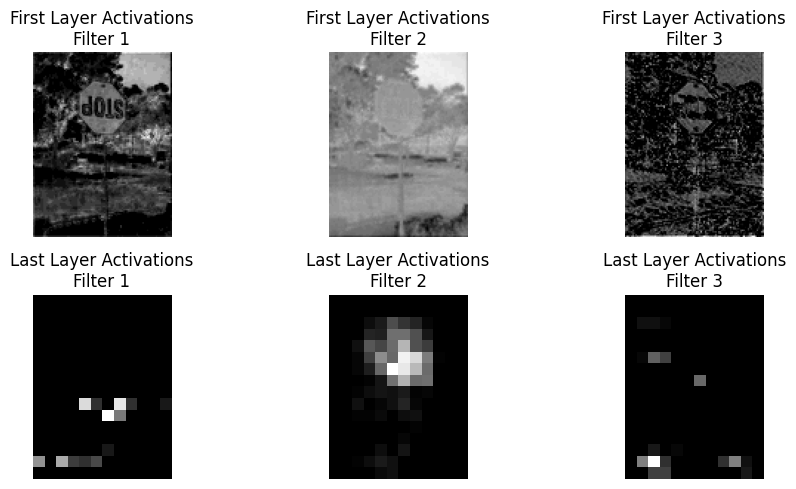

first_layer_activations:  torch.Size([256, 160, 107])
last_layer_activations:  torch.Size([2048, 20, 14])


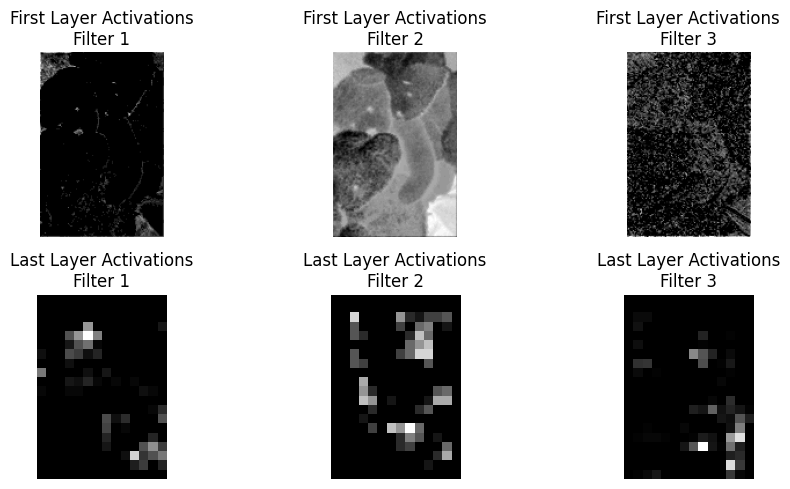

In [5]:
def activation_visualization(images, model, transform, show=False, save=True, split='val'):
    # Set the model to evaluation mode
    model.eval()
    output_dir = "output/activation_visualization/" + split + "/"

    for sample in images:

        # Read the image from disk using the image_name
        image_name = sample
        image = read_image(DATASET_DIR, image_name)
        image_tensor = transform(image).unsqueeze(0)

        # Forward pass through the model
        output = model(image_tensor)

        # Get the feature maps from the model
        feature_maps = model.backbone.body(image_tensor)
        first_layer_activations = feature_maps['0'][0]
        last_layer_activations = feature_maps['3'][0]
        print("first_layer_activations: ", first_layer_activations.shape)
        print("last_layer_activations: ", last_layer_activations.shape)

        # Nomralize the activations
        first_layer_activations = (first_layer_activations - first_layer_activations.min()) / (first_layer_activations.max() - first_layer_activations.min())
        last_layer_activations = (last_layer_activations - last_layer_activations.min()) / (last_layer_activations.max() - last_layer_activations.min())
        
        # Visualize the activations
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))

        # First layer activations for only the first 3 filters
        axes[0, 0].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[0]), cmap="gray")
        axes[0, 0].set_title("First Layer Activations\nFilter 1")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[1]), cmap="gray")
        axes[0, 1].set_title("First Layer Activations\nFilter 2")
        axes[0, 1].axis("off")

        axes[0, 2].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[2]), cmap="gray")
        axes[0, 2].set_title("First Layer Activations\nFilter 3")
        axes[0, 2].axis("off")

        # Last layer activations for only the first 3 filters
        axes[1, 0].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[0]), cmap="gray")
        axes[1, 0].set_title("Last Layer Activations\nFilter 1")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[1]), cmap="gray")
        axes[1, 1].set_title("Last Layer Activations\nFilter 2")
        axes[1, 1].axis("off")

        axes[1, 2].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[2]), cmap="gray")
        axes[1, 2].set_title("Last Layer Activations\nFilter 3")
        axes[1, 2].axis("off")

        plt.tight_layout()

        if save:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(output_dir + image_name)

        if show:
            plt.show()

# Constants
DATASET_DIR = "dataset/val2017/"
print("Loaded {} labels from COCO dataset".format(len(coco_labels)))

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the COCO dataset in "dataset/test2017"
test_images = os.listdir(DATASET_DIR)
test_images = test_images[:5]

# Apply activation visualization
activation_visualization(test_images, model, transform, show=True, save=True, split='val')

## Grad CAM

GRAD CAM (Gradient-weighted Class Activation Mapping) is a technique used to visualize and understand the regions of an image that are important for a deep learning model's prediction. It helps in interpreting the decision-making process of the model by highlighting the areas that contribute the most to the final prediction.

The main purpose of using GRAD CAM is to gain insights into how the model is focusing on specific regions of the input image to make its predictions. By visualizing the important regions, we can understand which parts of the image are influencing the model's decision and identify any biases or issues in the model.

To use GRAD CAM, you need to follow these steps:

1. Load the pre-trained model: In the provided code, a pre-trained Faster R-CNN model trained on the COCO dataset is loaded using `torchvision.models.detection.fasterrcnn_resnet50_fpn()`. This model is used for object detection.

2. Prepare the input data: The input images are loaded from the dataset directory and transformed using `torchvision.transforms.Compose()`.

3. Define the Grad CAM function: The `grad_cam()` function takes the images, model, transform, confidence threshold, IOU threshold, COCO labels, show flag, save flag, and split as input parameters. It sets the model to evaluation mode and defines the output directory for saving the results.

4. Iterate over the images: For each image, the function reads the image from disk, creates a copy of the original image, and transforms it into a tensor. The tensor is set to require gradients for backpropagation.

5. Predict boxes: The model predicts the bounding boxes, labels, and scores for the image using the `predict_boxes()` function.

6. Plot boxes: The function plots the predicted boxes on the image using the `plot_boxes()` function.

7. Backpropagate gradients: The gradients are backpropagated based on the predicted class scores. The model is zeroed out and the gradients are computed for each score.

8. Get activations and gradients: The activations from the last convolutional layer and the gradients of the output with respect to the last convolutional layer are obtained.

9. Compute Grad CAM heatmap: The Grad CAM heatmap is computed by multiplying the weights (mean values of gradients) with the last activation maps.

10. Normalize and resize Grad CAM heatmap: The Grad CAM heatmap is normalized and resized to match the input image size.

11. Visualize the results: The original image, predicted boxes, and Grad CAM heatmap are visualized using matplotlib.

12. Save or show the results: The results can be saved to the output directory or shown using the `save` and `show` flags.

By following these steps, you can use GRAD CAM to visualize and interpret the important regions in an image that contribute to the model's predictions.

Loaded 91 labels from COCO dataset


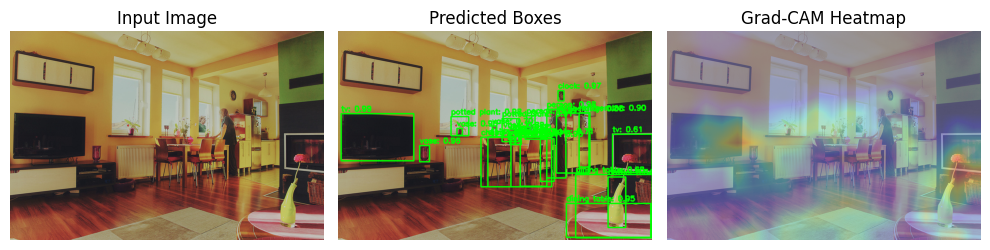

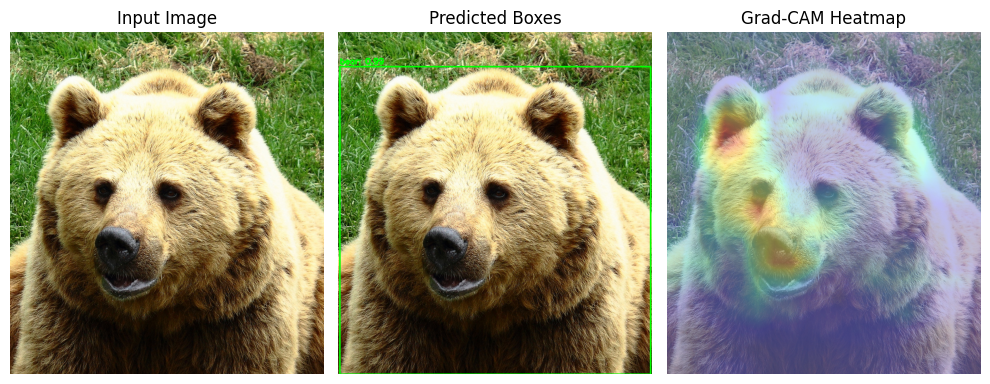

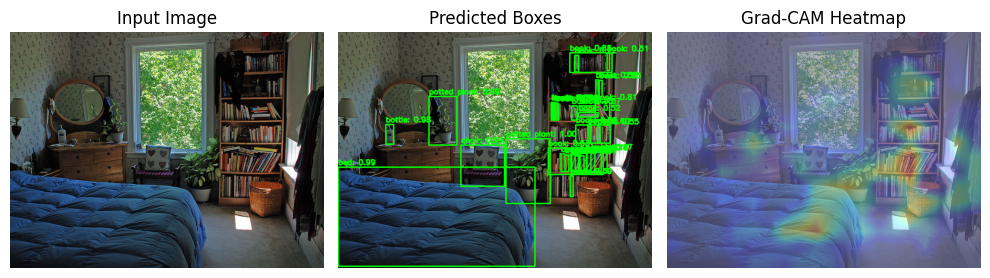

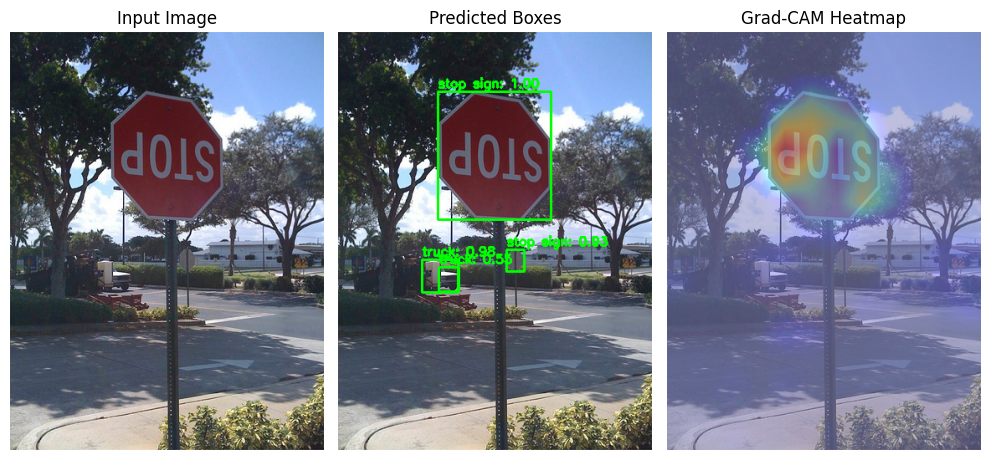

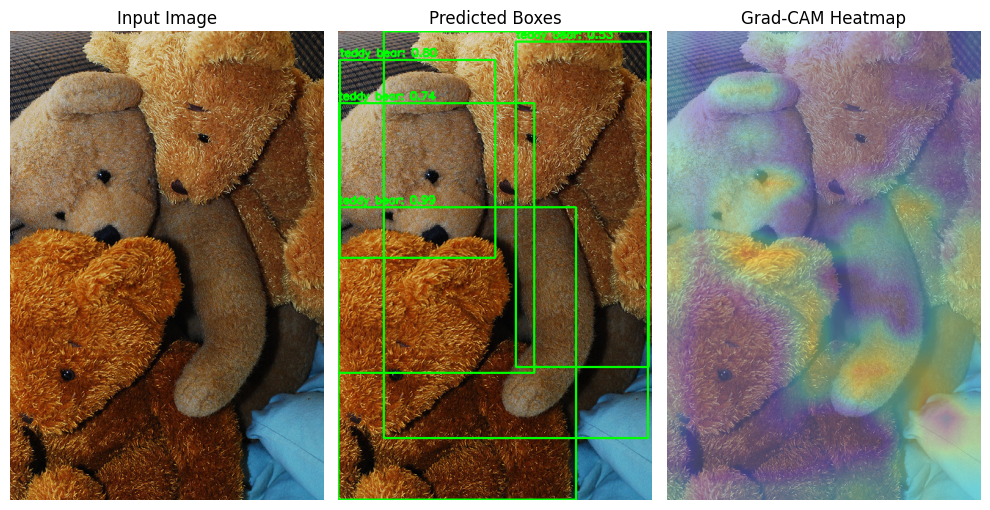

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
from coco_labels import get_coco_labels
import os
import numpy as np

# Define the Grad CAM function
def grad_cam(images, model, transform, confidence_threshold, iou_threshold, coco_labels, show = False, save = True, split='val'):

    # Set the model to evaluation mode
    model.eval()
    output_dir = "output/gradcam/" + split + "/confidence_threshold_" + str(confidence_threshold) + "_iou_threshold_" + str(iou_threshold) + "/"

    for sample in images:

        # Read the image from disk using the image_name
        image_name = sample
        image = read_image(DATASET_DIR, sample)
        original_image = image.copy()
        image_tensor = transform(image).unsqueeze(0)
        image_tensor.requires_grad = True  

        boxes, labels, scores = predict_boxes(model, image_tensor, confidence_threshold, iou_threshold)

        image = plot_boxes(image, boxes, labels, scores, coco_labels)

        # Backpropagate the gradients based on the predicted class score
        model.zero_grad()
        for score in scores:
            score.backward(retain_graph=True)
        
        # Get the activations from the last convolutional layer
        last_activation = model.backbone.body(image_tensor)['3'][0].detach().numpy()

        # Get the gradients of the output with respect to the last convolutional layer
        grads = model.backbone.body.layer4[2].conv3.weight.grad.detach().numpy()
        grads = grads.squeeze(axis=(2, 3))

        # Get the mean value of the gradients for every feature map
        weights = np.mean(grads, axis=(1))

        grad_cam = np.zeros(last_activation.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * last_activation[i, :, :]


        # Normalize Grad-CAM heatmap
        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

        # Resize Grad-CAM heatmap to match the input image size
        grad_cam = cv2.resize(grad_cam, (image.shape[1], image.shape[0]))

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        # Input image
        axes[0].imshow(original_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Predicted box within the image
        axes[1].imshow(image)
        axes[1].set_title("Predicted Boxes")
        axes[1].axis("off")

        # Grad-CAM heatmap
        axes[2].imshow(grad_cam, cmap='jet', alpha=0.5)
        axes[2].imshow(original_image, alpha=0.5)
        axes[2].set_title("Grad-CAM Heatmap")
        axes[2].axis("off")

        plt.tight_layout()

        if save:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(output_dir + image_name)

        if show:
            plt.show()


# Constants
DATASET_DIR = "dataset/val2017/"
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
coco_labels = get_coco_labels()
print("Loaded {} labels from COCO dataset".format(len(coco_labels)))

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the COCO dataset in "dataset/test2017"
test_images = os.listdir(DATASET_DIR)
test_images = test_images[:5]

# Apply Grad CAM
grad_cam(test_images, model, transform, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, coco_labels, show=True, save=True, split='val')

## Attention Visualization

## EigenCAM

## Ablation CAM

## Score CAM

## Concept Activation Maps

## Deep Feature Factorizations